In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 正解率の分析

In [2]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)

### accuracyの分析

scale=intended -> no_stripe_accuracy: 1.00
scale=50cm -> no_stripe_accuracy: 1.00
scale=75cm -> no_stripe_accuracy: 0.96
scale=100cm -> no_stripe_accuracy: 0.89


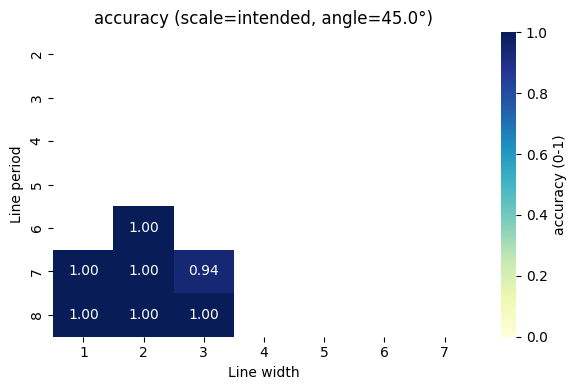

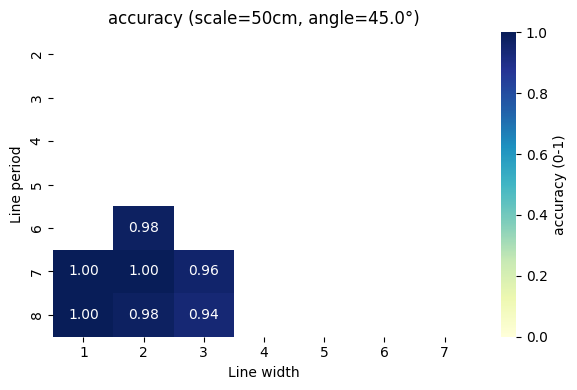

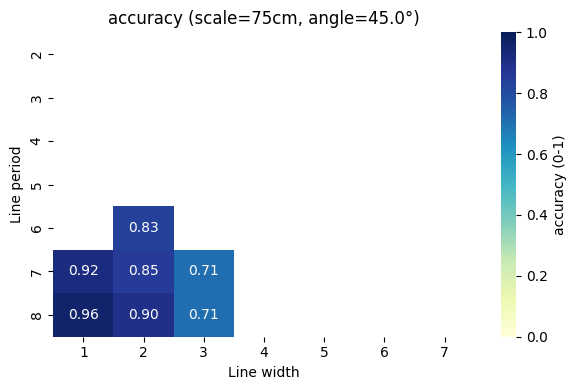

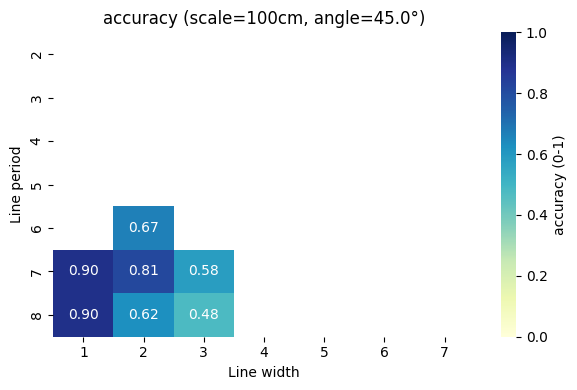

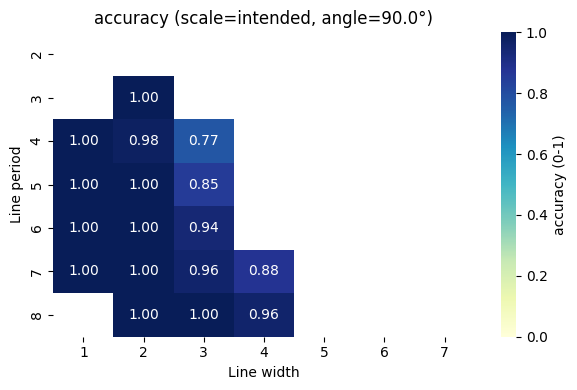

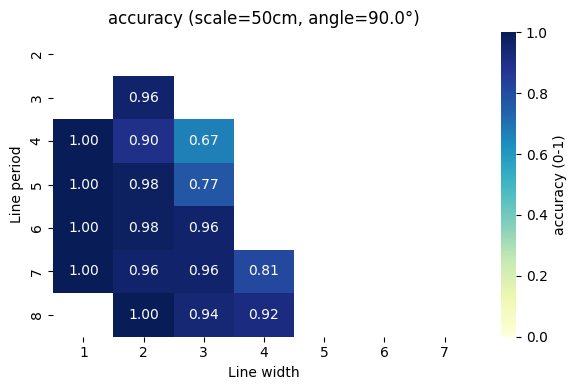

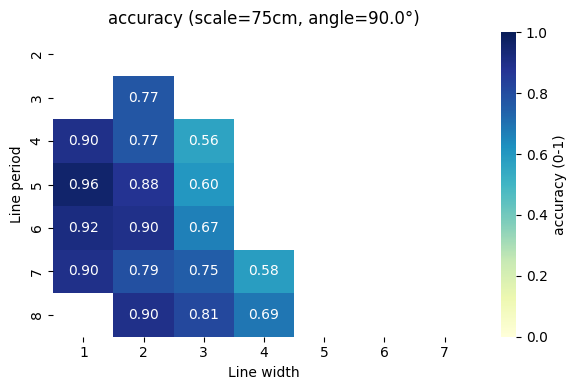

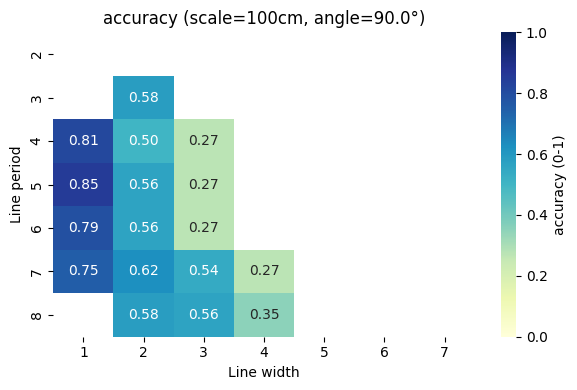

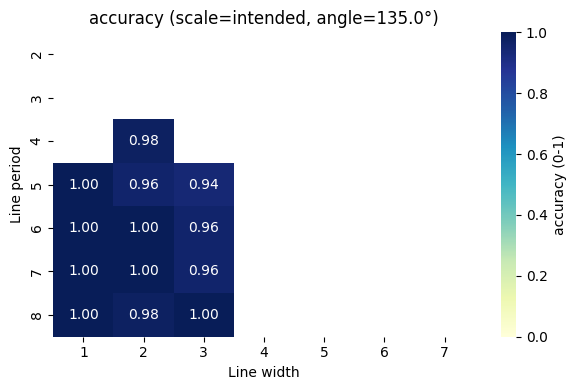

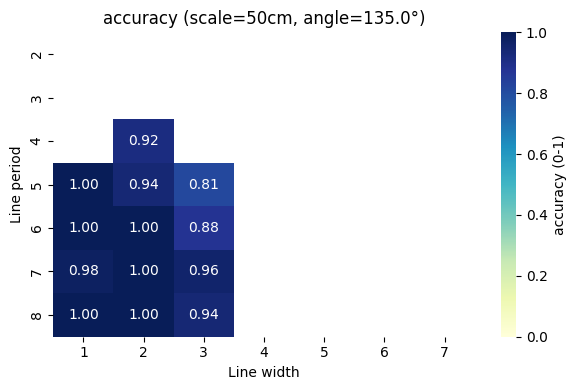

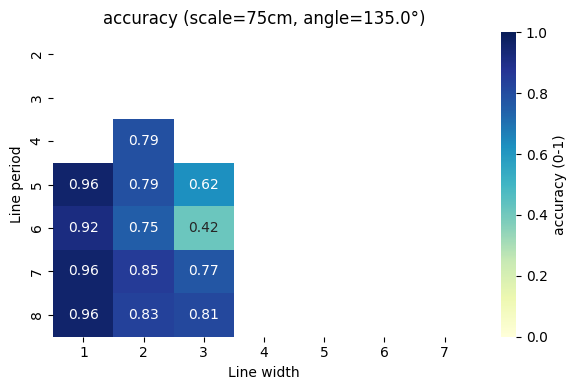

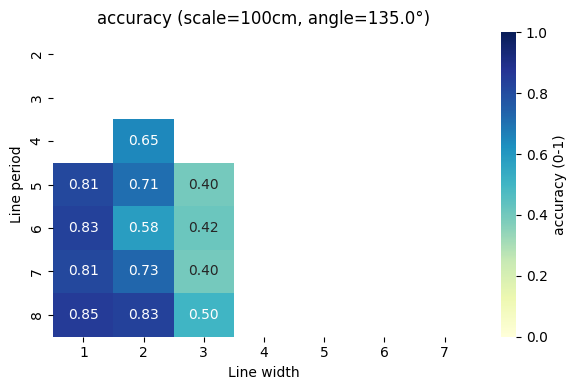

In [3]:
sf_values = sorted(df['scale'].unique())
angle_values = sorted(df['angle'].unique())

# 集計: type, scale_factor, duty_cycle, line_period, line_angle ごとのサマリ
summary = df.groupby(['scale','line_width','period','angle']).agg(
    n=('accuracy','size'),
    mean_acc=('accuracy','mean'),
).reset_index()

# 角度ごとに line_period × line_width の平均精度を計算してヒートマップを描画
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    scale_order = ["intended", "50cm", "75cm", "100cm"]
    for scale in scale_order:
        sub_scale = sub[sub['scale'] == scale]

        # グルーピングして平均
        pivot = sub_scale.groupby(['period', 'line_width'])['accuracy'].mean().unstack()
        
        #line_width == 0 のときは精度だけ出力して終了
        if 0 in pivot.columns:
            # 最も小さい period 行から取る（0行が無い可能性を考慮）
            base_period = pivot.index.min()
            no_stripe_acc = pivot.loc[base_period, 0]
            print(f'scale={scale} -> no_stripe_accuracy: {no_stripe_acc:.2f}')
            continue

        #軸を固定
        x_index = list(range(1, 8))
        y_index = list(range(2, 9))
        pivot = pivot.reindex(index=y_index, columns=x_index)

        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'accuracy (0-1)'})
        plt.title(f'accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        plt.show()


### TorFの分析

scale=intended, angle=0.0° -> no_stripe_accuracy (TorF based): 1.00
scale=50cm, angle=0.0° -> no_stripe_accuracy (TorF based): 1.00
scale=75cm, angle=0.0° -> no_stripe_accuracy (TorF based): 0.92
scale=100cm, angle=0.0° -> no_stripe_accuracy (TorF based): 0.86


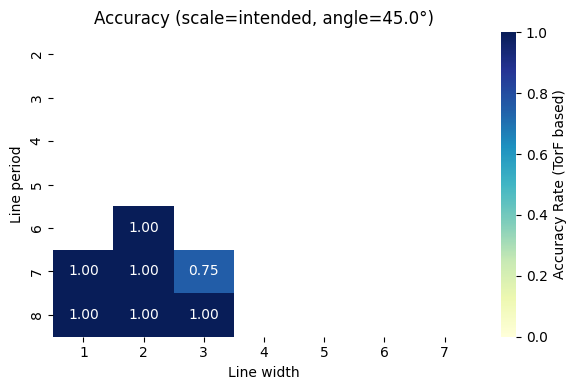

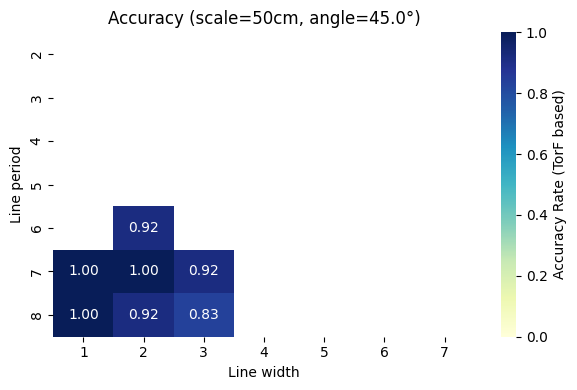

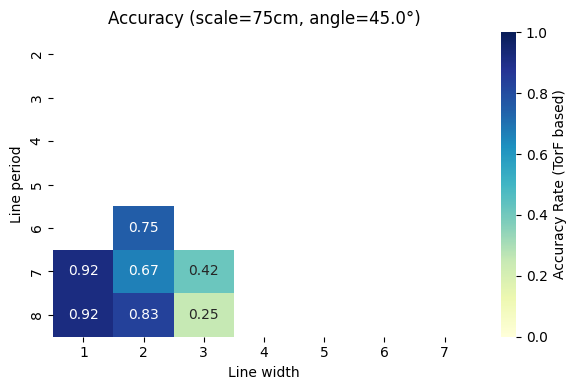

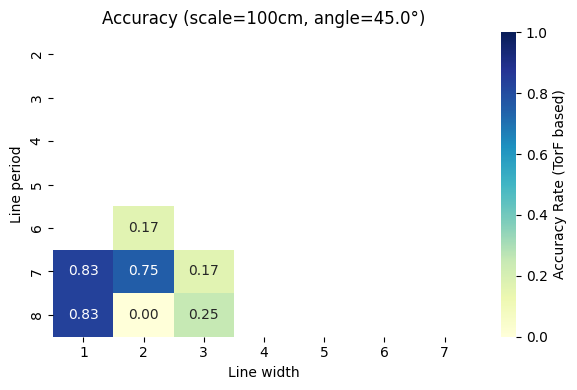

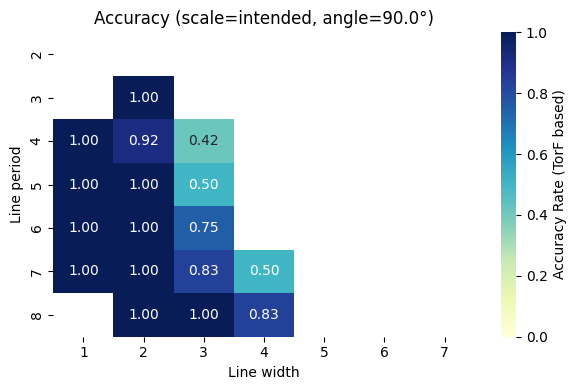

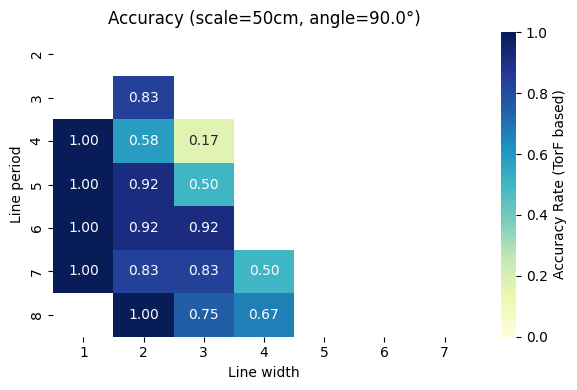

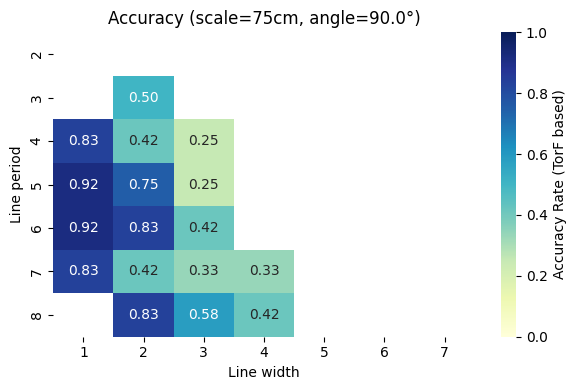

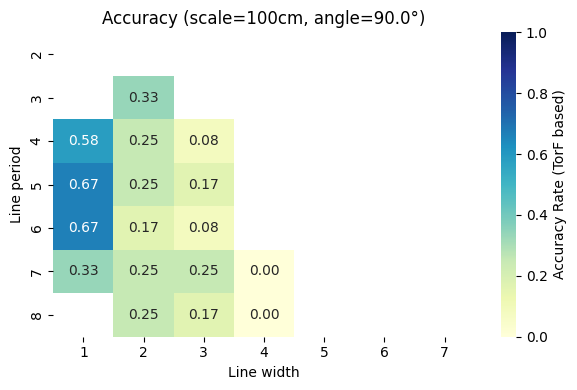

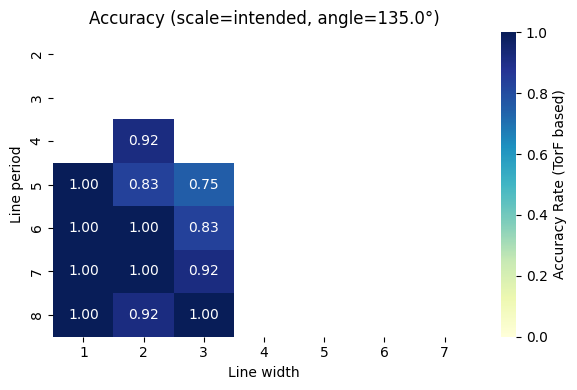

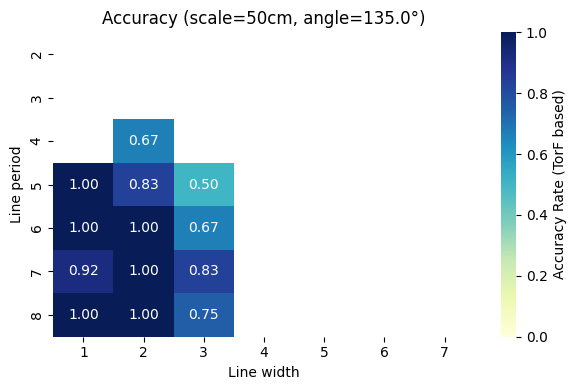

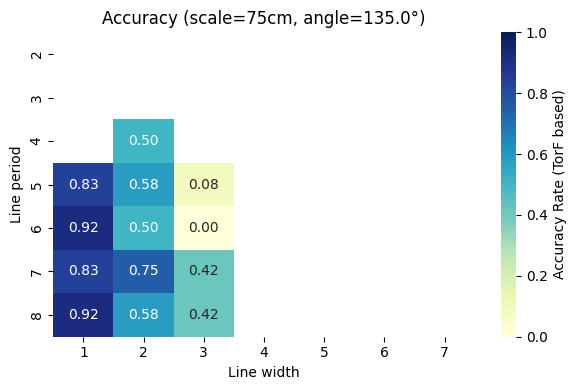

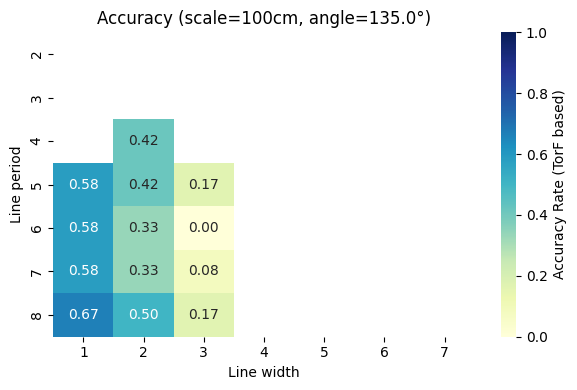

In [4]:
# データ前処理
# 'T'を1(正解)、'F'を0(不正解)に変換します。
df['correct_flag'] = df['TorF'].map({'T': 1, 'F': 0})

scale_order = ["intended", "50cm", "75cm", "100cm"]

# 角度ごとにループ
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    
    for scale in scale_order:
        # 該当スケールのデータがない場合はスキップ
        if scale not in sub['scale'].values:
            continue
            
        sub_scale = sub[sub['scale'] == scale]

        # グルーピングして「正解した割合（correct_flagの平均）」を算出
        # Z軸 = correct_flag の mean
        pivot = sub_scale.groupby(['period', 'line_width'])['correct_flag'].mean().unstack()
        
        # line_width == 0 (縞模様なし) の扱い
        if 0 in pivot.columns:
            # 最も小さい period 行から取る（0行が無い可能性を考慮）
            base_period = pivot.index.min()
            no_stripe_acc = pivot.loc[base_period, 0]
            print(f'scale={scale}, angle={angle}° -> no_stripe_accuracy (TorF based): {no_stripe_acc:.2f}')
            continue

        # 軸を固定 (元コードの設定を維持)
        x_index = list(range(1, 8)) # line_width
        y_index = list(range(2, 9)) # period
        
        # 指定したインデックス・カラムで再構築（存在しない箇所はNaNまたは空欄になります）
        pivot = pivot.reindex(index=y_index, columns=x_index)

        # ヒートマップ描画
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'Accuracy Rate (TorF based)'})
        
        plt.title(f'Accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        plt.show()

# 時間の分析

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
#正解のデータのみ使用
df = df[df['TorF'] == 'T'].copy()

# ベースライン条件の定義
baseline_condition = (df["scale"] == "intended") & (df["line_width"] == 0.0)

# 被験者IDごとにベースライン時間の平均を算出 
participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

print("=== Participant Baselines ===")
print(participant_baselines)

# 元のデータフレームに個別のベースライン時間をマッピング
df['individual_baseline'] = df['participant_id'].map(participant_baselines)

scale_order = ["intended", "50cm", "75cm", "100cm"]

=== Participant Baselines ===
participant_id
402    3144.000000
404    4752.000000
406    2949.666667
408    3970.000000
410    2206.333333
411    2725.666667
412    1867.666667
413    2417.666667
414    3262.666667
415    4703.666667
417    2722.000000
419    3565.333333
Name: time, dtype: float64


### 時間差の分析

=== angle=0.0° ===
  - scale=intended


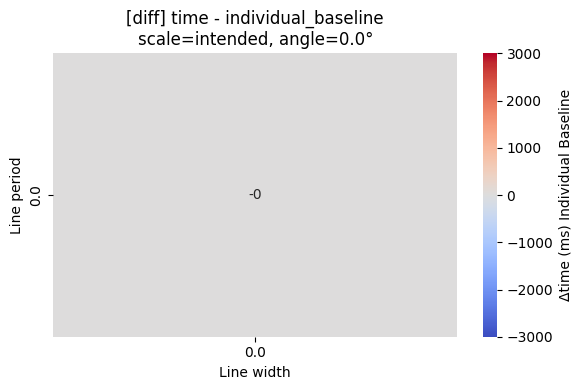

  - scale=50cm


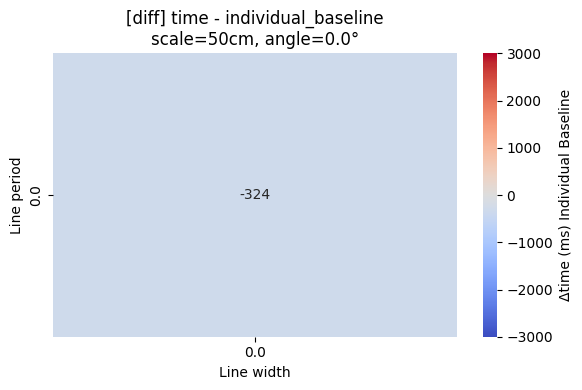

  - scale=75cm


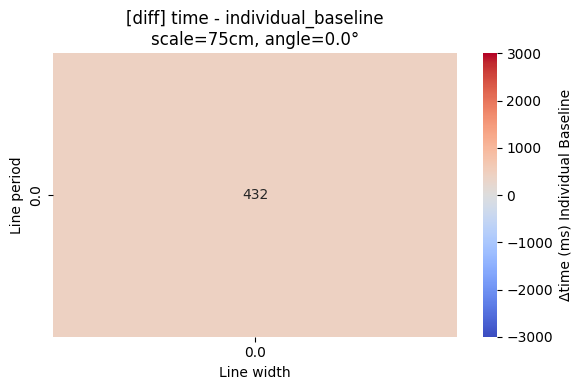

  - scale=100cm


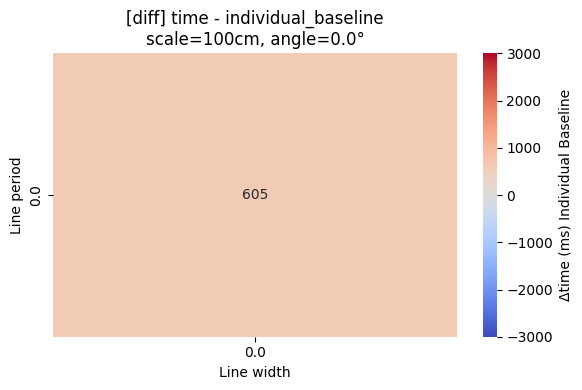

=== angle=45.0° ===
  - scale=intended


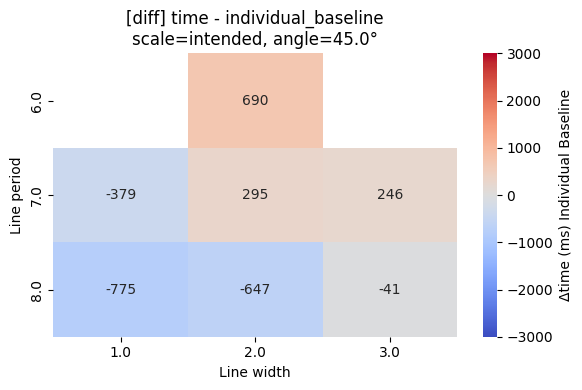

  - scale=50cm


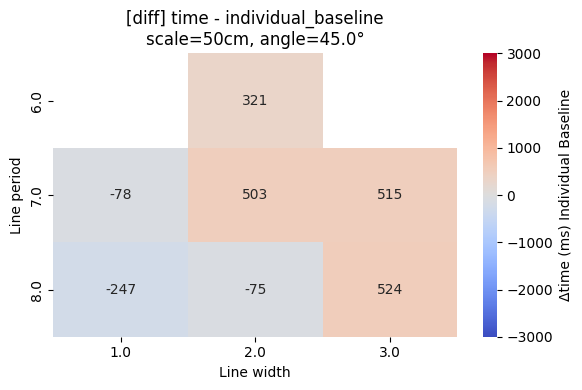

  - scale=75cm


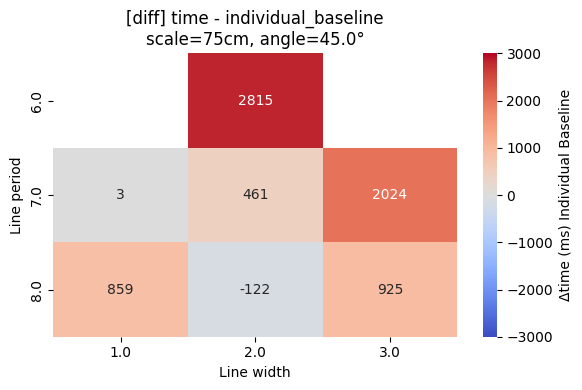

  - scale=100cm


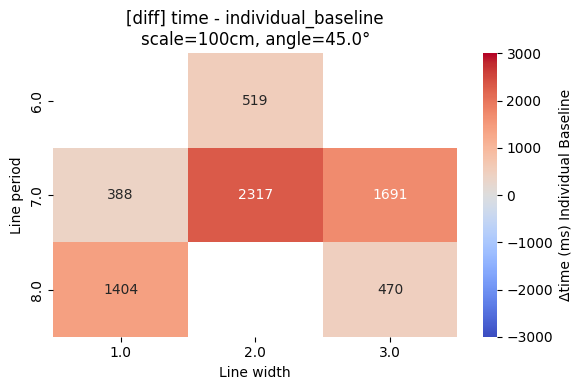

=== angle=90.0° ===
  - scale=intended


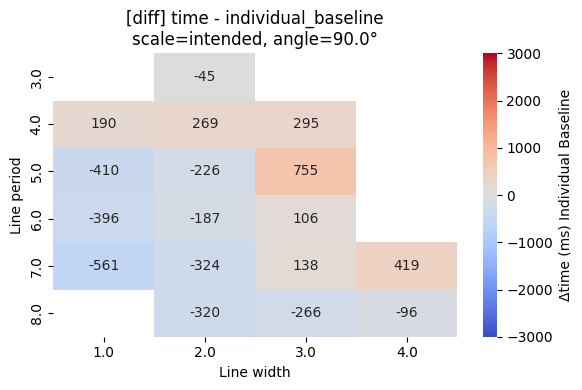

  - scale=50cm


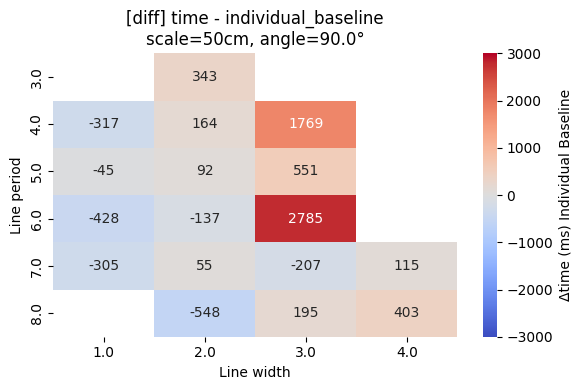

  - scale=75cm


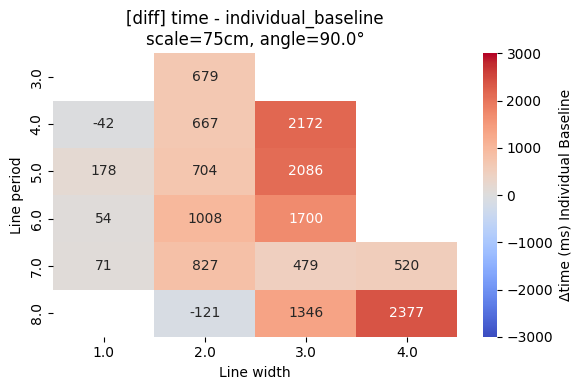

  - scale=100cm


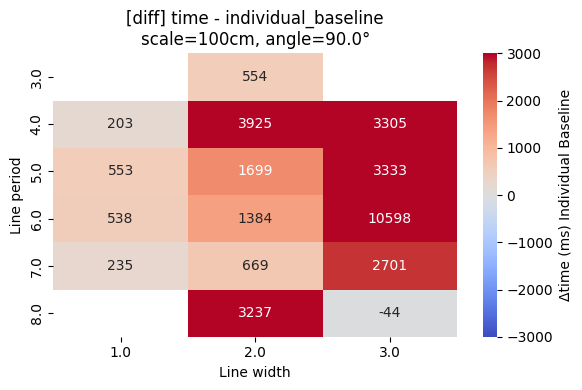

=== angle=135.0° ===
  - scale=intended


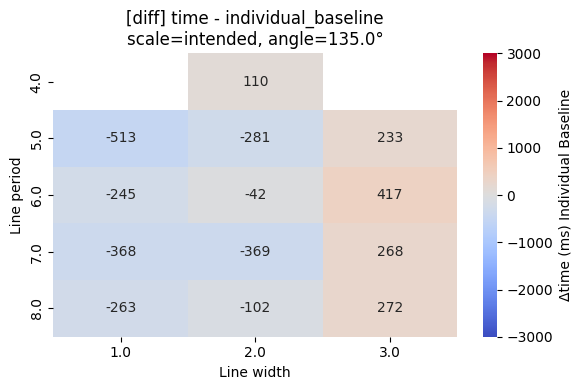

  - scale=50cm


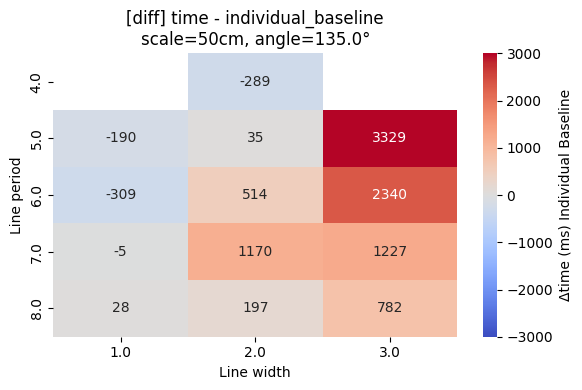

  - scale=75cm


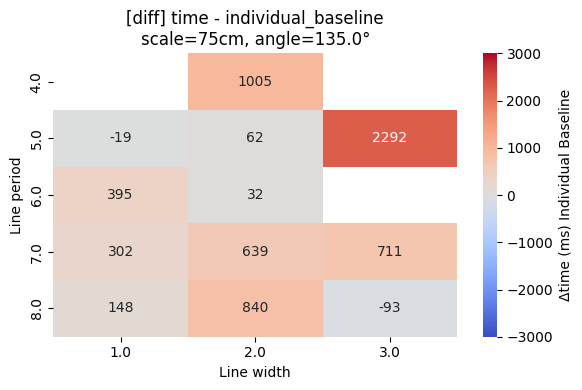

  - scale=100cm


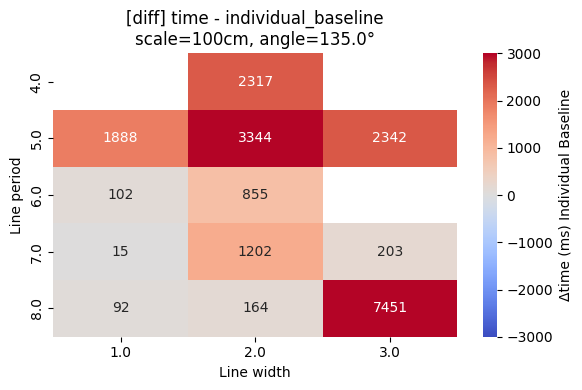

In [ ]:
# ベースラインとの差分を計算 (Delta time)
df['time_diff'] = df['time'] - df['individual_baseline']

for angle in sorted(df["angle"].unique()):
    print(f"=== angle={angle}° ===")

    angle_df = df[df["angle"] == angle]

    for scale in scale_order:
        print(f"  - scale={scale}")

        sub = angle_df[angle_df["scale"] == scale]
        if len(sub) == 0:
            print("    データなし → skip")
            continue

        # --- 平均値 pivot ---
        pivot_mean = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time_diff",  
            aggfunc="mean"       
        )

        if pivot_mean.isna().all().all():
            print("    pivot が NaN → skip")
            continue 

        diff = pivot_mean 

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            diff,
            vmax=3000,
            vmin=-3000,
            annot=True,
            fmt=".0f",
            cmap="coolwarm",
            center=0,
            cbar_kws={'label': 'Δtime (ms) Individual Baseline'}
        )
        plt.title(f"[diff] time - individual_baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()

### 時間割合の分析

=== angle=0.0° ===
  - scale=intended


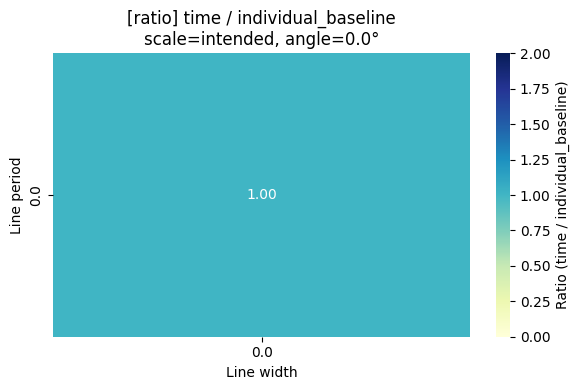

  - scale=50cm


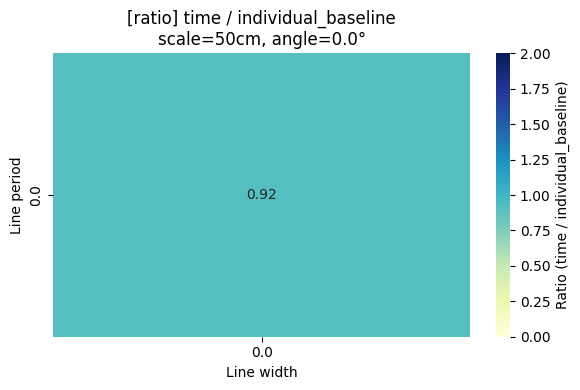

  - scale=75cm


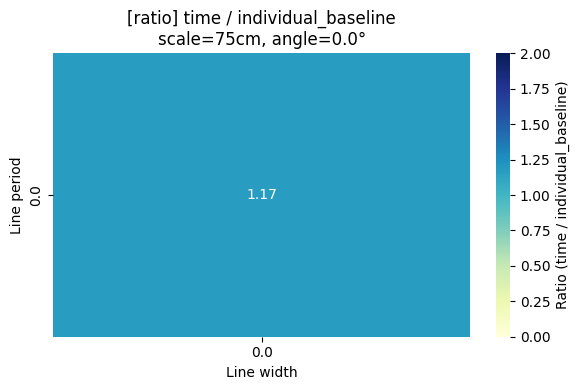

  - scale=100cm


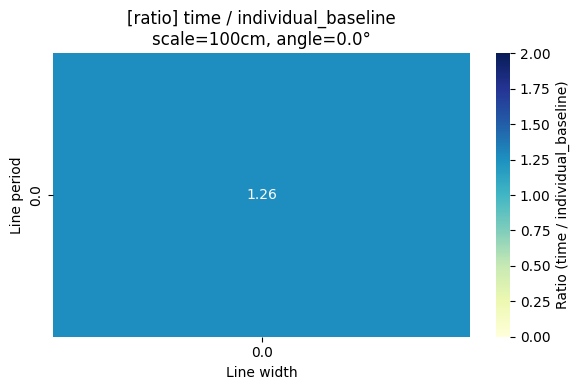

=== angle=45.0° ===
  - scale=intended


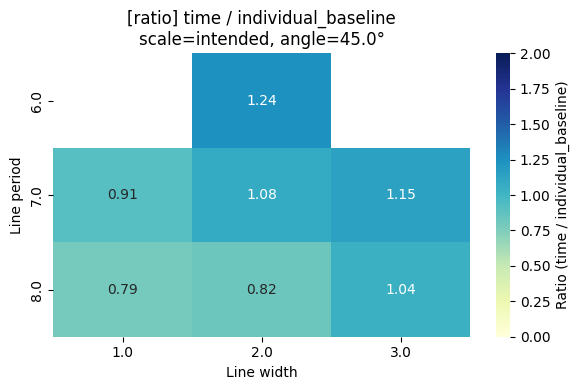

  - scale=50cm


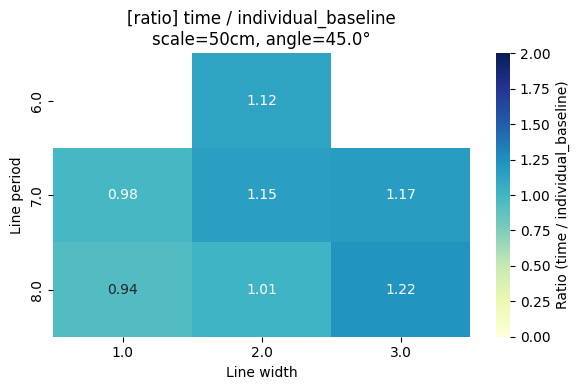

  - scale=75cm


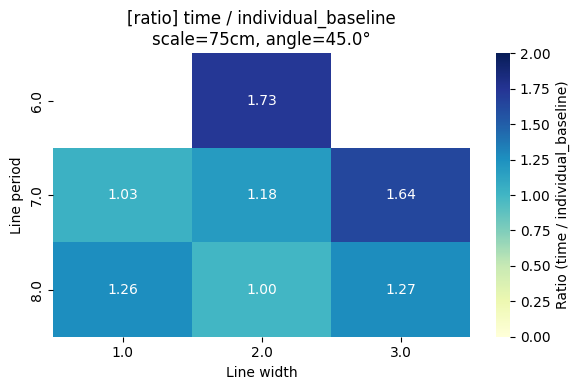

  - scale=100cm


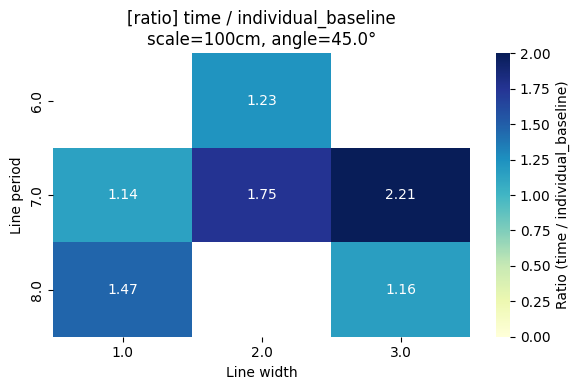

=== angle=90.0° ===
  - scale=intended


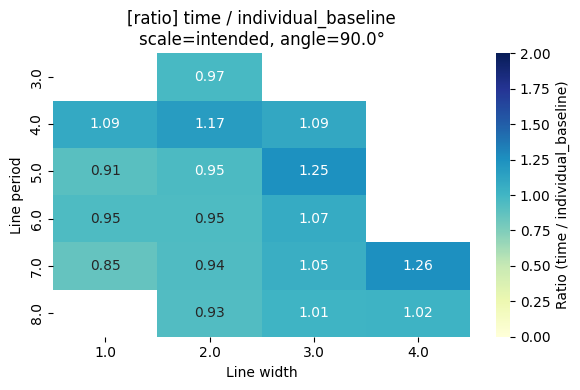

  - scale=50cm


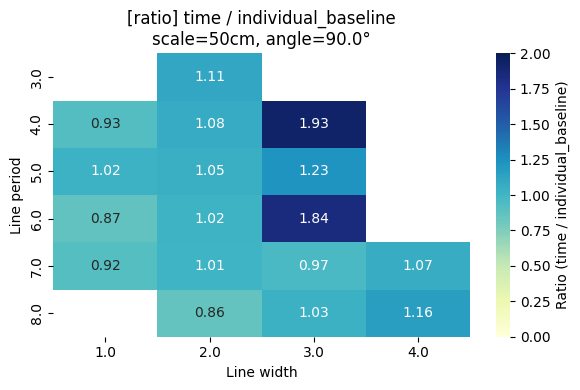

  - scale=75cm


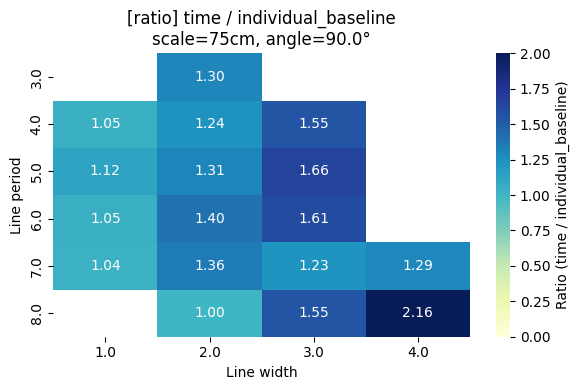

  - scale=100cm


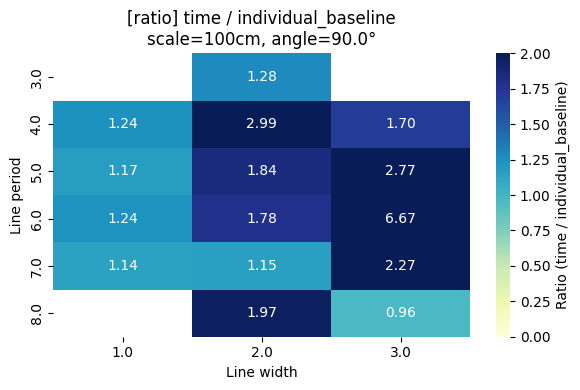

=== angle=135.0° ===
  - scale=intended


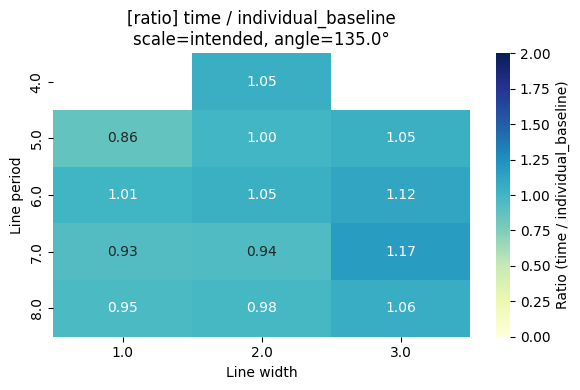

  - scale=50cm


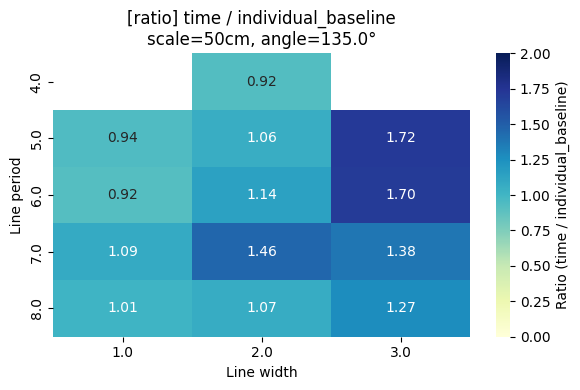

  - scale=75cm


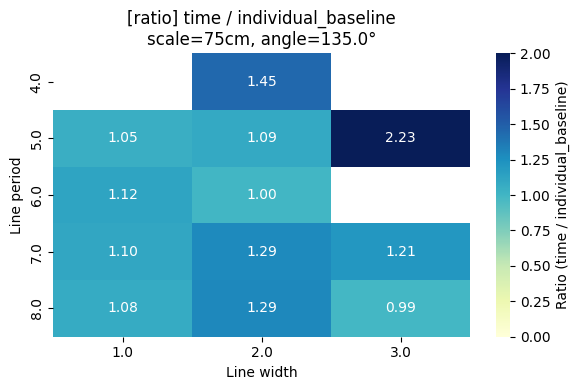

  - scale=100cm


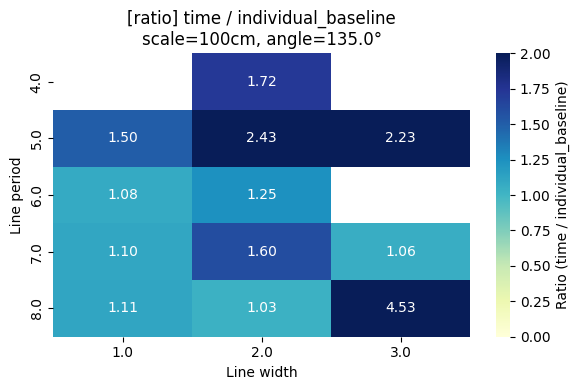

In [15]:
# 各試行について「その人のベースラインに対する比率」を計算
# 1.0 なら変化なし、1.5 なら1.5倍の時間がかかったことになります
df['time_ratio'] = df['time'] / df['individual_baseline']

for angle in sorted(df["angle"].unique()):
    print(f"=== angle={angle}° ===")

    angle_df = df[df["angle"] == angle]

    for scale in scale_order:
        print(f"  - scale={scale}")

        sub = angle_df[angle_df["scale"] == scale]
        if len(sub) == 0:
            print("    データなし → skip")
            continue

        # --- 平均値 pivot ---
        pivot_mean = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time_ratio",  
            aggfunc="mean"       
        )

        if pivot_mean.isna().all().all():
            print("    pivot が NaN → skip")
            continue

        ratio = pivot_mean

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            ratio,
            annot=True,
            vmax=2.0,
            vmin=0.0,
            fmt=".2f",
            cmap="YlGnBu",
            center=1.0, # 必要であれば 1.0（変化なし）をカラーマップの中心にする
            cbar_kws={'label': 'Ratio (time / individual_baseline)'}
        )
        plt.title(f"[ratio] time / individual_baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()